In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
# we can add month as feature but not added as of now
original_df =pd.read_csv('../input/MRDS_Index_Data_D_Labs_Training_Updated.csv',parse_dates=True,index_col='Date')
subset_df = original_df['2007':'2018'] 
subset_df['Month'] = subset_df.index.month
subset_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Beef_CS_LiveWgt_PerHd,Beef_CS_Slaughter_Cnt,Beef_ME_Exp_cwt,Beef_ME_Imp_cwt,OP_Electricity_Index,OP_Fuel_Oil_Index,OP_Utility_Gas_Index,OP_Gasoline_Index,OP_Soyabean_Index,OP_Hay_Alfalfa_Index,...,Extreme_Draught_Value,Dollar_Index,Egg_Index,Ground_Beef_Index,Round_Index,Beef_Steak_Index,Ham_Index,Pork_Chops_Index,Bacon_Index,Month
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1290,2800.3,88015.60,270127.44,168.903,232.476,217.428,73.0,109.0,212.1,...,80.1480,94.812,176.588,177.805,146.626,146.440,172.747,165.741,213.161,1
2007-02-01,1274,2561.2,88273.90,223064.59,168.870,238.651,218.173,60.1,105.6,215.8,...,81.4600,94.643,190.534,180.997,151.905,146.366,170.358,166.031,217.949,2
2007-03-01,1260,2793.0,92747.49,276724.42,169.346,245.141,222.221,66.1,108.3,221.4,...,86.0475,94.397,184.878,181.778,152.622,150.995,176.106,169.230,215.625,3
2007-04-01,1235,2701.4,105205.87,301300.99,169.385,249.477,220.779,71.1,113.1,236.1,...,86.4200,93.274,178.626,182.456,158.206,155.146,169.135,168.387,215.400,4
2007-05-01,1232,3051.4,126889.87,302812.03,172.342,250.627,221.801,86.1,118.4,265.6,...,93.0160,92.615,183.757,184.626,155.751,154.565,176.349,173.426,223.565,5


In [4]:
target_names = ['Bacon_Index']
shift_months = 12 

In [5]:
df_targets = subset_df [target_names].shift(-shift_months)

In [6]:
df_targets.head()

,Bacon_Index
Date,
2007-01-01,217.441
2007-02-01,216.966
2007-03-01,216.824
2007-04-01,216.807
2007-05-01,215.096


In [7]:
test_df = subset_df.tail(12)

In [8]:
traning_df = subset_df[:-12]

In [9]:
feature_columns = ['DG_Pop_Size_mm', 'ME_CPI', 'Bacon_Index', 'ME_AvgHrInc_Trk_Driver',
       'Ground_Beef_Index', 'Ham_Index', 'Round_Index', 'Beef_Steak_Index',
       'Beef_ME_Exp_cwt', 'Pork_Chops_Index', 'OP_Electricity_Index',
       'Pork_CS_LiveWgt_PerHd', 'OP_Gasoline_Index', 'Pork_ME_Exp_cwt',
       'Beef_CS_LiveWgt_PerHd', 'OP_Hay_Others_Prc', 'OP_Hay_Alfalfa_Index',
       'Egg_Index', 'OP_Corn_Index', 'Pork_CS_ColdStrg_Stock_pwt',
       'Extreme_Draught_Value', 'OP_Soyabean_Index',
       'Pork_CS_ColdStrg_Stock_cwt', 'Pork_ME_Imp_cwt', 'Pork_CS_Prod_Qty',
       'WR_Avg_Rainfall', 'OP_Fuel_Oil_Index', 'Dollar_Index',
       'Beef_CS_Prod_Qty', 'CS_Cattle_On_Feed_Invt', 'Beef_CS_Slaughter_Cnt',
       'OP_Utility_Gas_Index']

In [10]:
limited_feature_traning_df = traning_df[feature_columns]

In [11]:
limited_feature_traning_df.head()

,DG_Pop_Size_mm,ME_CPI,Bacon_Index,ME_AvgHrInc_Trk_Driver,Ground_Beef_Index,Ham_Index,Round_Index,Beef_Steak_Index,Beef_ME_Exp_cwt,Pork_Chops_Index,...,Pork_CS_ColdStrg_Stock_cwt,Pork_ME_Imp_cwt,Pork_CS_Prod_Qty,WR_Avg_Rainfall,OP_Fuel_Oil_Index,Dollar_Index,Beef_CS_Prod_Qty,CS_Cattle_On_Feed_Invt,Beef_CS_Slaughter_Cnt,OP_Utility_Gas_Index
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,299.89,202.42,213.161,17.50,177.805,172.747,146.626,146.440,88015.60,165.741,...,493.35,72565.25,1898.5,46.39,232.476,94.812,2166.0,11974,2800.3,217.428
2007-02-01,300.10,203.50,217.949,17.47,180.997,170.358,151.905,146.366,88273.90,166.031,...,539.99,77317.26,1636.3,33.98,238.651,94.643,1952.5,11726,2561.2,218.173
2007-03-01,300.29,205.35,215.625,17.52,181.778,176.106,152.622,150.995,92747.49,169.230,...,539.42,89382.99,1861.0,46.06,245.141,94.397,2118.2,11599,2793.0,222.221
2007-04-01,300.51,206.69,215.400,17.51,182.456,169.135,158.206,155.146,105205.87,168.387,...,552.63,85218.40,1711.5,48.40,249.477,93.274,2015.0,11644,2701.4,220.779
2007-05-01,300.73,207.95,223.565,17.60,184.626,176.349,155.751,154.565,126889.87,173.426,...,590.81,85744.99,1762.6,56.15,250.627,92.615,2285.1,11297,3051.4,221.801


In [12]:
x_data = limited_feature_traning_df.values
print(x_data.shape)

(113, 32)


In [13]:
y_data = df_targets.values[:-shift_months]
print(y_data.shape)

(113, 1)


In [14]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_data,y_data,test_size = 0.1,shuffle=False)

In [15]:
# Number of input features
num_x_signals = x_data.shape[1]
num_x_signals

32

In [16]:
# number of target
num_y_signals = y_data.shape[1]
num_y_signals

1

In [17]:
# scale Data
x_scalerx_scaler = MinMaxScaler()
x_train_scaled = x_scalerx_scaler.fit_transform(x_train)
x_scaled_val = x_scalerx_scaler.fit_transform(x_val)

In [18]:
print(x_train_scaled.shape)
print(y_train.shape)

(101, 32)
(101, 1)


In [19]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(len(x_train_scaled) - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [20]:
# batch size and sequence
batch_size = 30
sequence_length= 12*1 # we will go four years data at a time

In [21]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [22]:
x_batch, y_batch = next(generator)

In [23]:
validation_data = (np.expand_dims(x_scaled_val, axis=0),
                   np.expand_dims(y_val, axis=0))

In [24]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,),
              dropout = 0.5))
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, 512,),
              dropout = 0.5))

model.add(Dense(num_y_signals, activation='relu'))

In [25]:
optimizer = RMSprop(lr=1e-3)

In [26]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """


    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true,
                                        predictions=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [27]:
model.compile(loss=loss_mse_warmup, 
              optimizer=optimizer)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         837120    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 512)         1574400   
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 2,412,033
Trainable params: 2,412,033
Non-trainable params: 0
_________________________________________________________________


In [29]:
# call back function
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping  = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [30]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [31]:
%%time
model.fit_generator(generator=generator,
                    epochs=50,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 43009.5494
Epoch 00001: val_loss improved from inf to 41668.21875, saving model to 23_checkpoint.keras
100/100 [==============================] - 7s 70ms/step - loss: 42891.3019 - val_loss: 41668.2188
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 24564.3661
Epoch 00002: val_loss improved from 41668.21875 to 23821.10156, saving model to 23_checkpoint.keras
100/100 [==============================] - 6s 57ms/step - loss: 24512.9094 - val_loss: 23821.1016
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 11779.3276
Epoch 00003: val_loss improved from 23821.10156 to 11125.72754, saving model to 23_checkpoint.keras
100/100 [==============================] - 6s 56ms/step - loss: 11736.8558 - val_loss: 11125.7275
Epoch 4/50
 99/100 [============================>.] - ETA: 0s - loss: 4149.0670
Epoch 00004: val_loss improved from 11125.72754 to 3440.80396, saving model to 23_checkpoin

In [32]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [33]:
result = model.evaluate(x=np.expand_dims(x_scaled_val, axis=0),
                        y=np.expand_dims(y_val, axis=0))

1/1 [==============================] - 0s 16ms/step


In [34]:
print("loss (test-set):", result)

loss (test-set): 61.914981842041016


In [35]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_scaled_val
        y_true = y_val
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_pred[0]
    
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        print(signal_pred)
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        print(signal_true)

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

(1, 100, 32)
[216.52974 219.04396 219.93915 220.02528 220.0506  220.06686 220.13559
 220.31181 220.23317 220.09889 220.07373 220.05443 220.03366 220.01038
 219.97826 219.93675 219.87245 219.74821 219.63821 219.55745 219.5165
 219.49985 219.5503  219.63274 219.7223  219.82045 219.92267 220.8898
 227.14163 232.92236 240.14485 249.12236 257.15445 255.88306 243.64243
 239.57896 240.19742 245.36667 257.80856 269.5245  270.28162 270.0149
 269.8091  269.69833 269.68283 269.6129  269.50647 269.46933 269.4646
 269.5472  269.5512  269.50928 269.5116  269.52042 269.55453 269.55426
 269.5317  269.53632 269.4968  269.4875  269.5103  269.5928  269.56128
 269.55225 269.59506 269.77658 269.9404  269.8928  269.90482 269.79596
 269.74167 269.7586  269.73932 269.77713 269.771   269.8562  269.9163
 269.98996 269.9813  269.9883  269.97995 269.90494 269.79196 269.7271
 269.76663 269.87994 269.98373 270.05246 270.0767  270.09384 270.344
 270.5396  270.72266 270.42224 270.42538 270.3065  270.33173 270.7369
 2

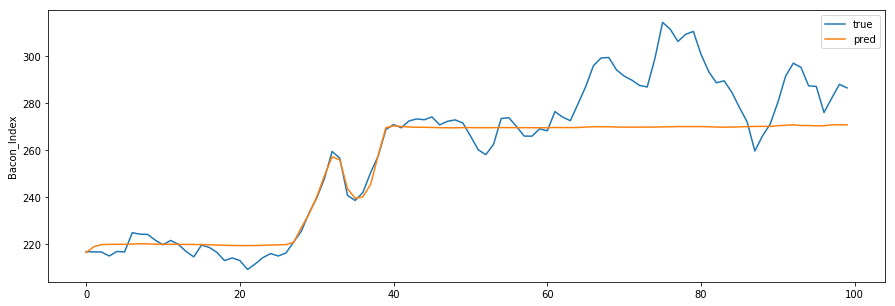

In [36]:
warmup_steps = 0
plot_comparison(start_idx=1, length=100, train=True)

(1, 11, 32)
[284.1594  283.00632 285.67288 288.2699  287.7456  287.53223 287.0444
 288.1984  290.28363 289.57422 289.99585]
[284.678 283.764 286.278 283.33  276.043 275.491 280.692 286.254 300.654
 301.45  296.531]


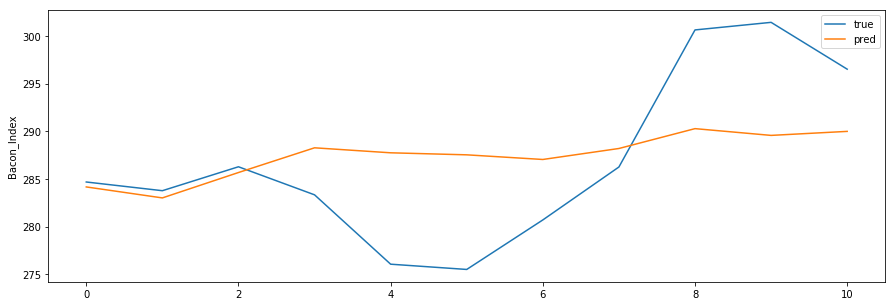

In [37]:
plot_comparison(start_idx=1, length=100, train=False)

In [38]:
predict = np.expand_dims(x_scalerx_scaler.fit_transform(test_df[feature_columns]), axis=0)

In [39]:
predict.shape

(1, 12, 32)

In [40]:
predcicted_values = model.predict(predict)

In [41]:
predcicted_values

array([[[287.40634],
        [283.7732 ],
        [285.87393],
        [287.63458],
        [289.72485],
        [290.91916],
        [291.09503],
        [290.7161 ],
        [289.86084],
        [290.28564],
        [288.4873 ],
        [287.9462 ]]], dtype=float32)